**Load Dataset**

Load Dataset Wajah

In [ ]:
from torch.utils.data import Dataset
import os
import torch

class ProcessedVideoDataset(Dataset):
    def __init__(self, pt_folder):
        self.pt_folder = pt_folder
        self.pt_files = [os.path.join(pt_folder, f) for f in os.listdir(pt_folder) if f.endswith('.pt')]
        self.file_list = sorted([
            f for f in os.listdir(pt_folder)
            if f.endswith('.pt')
        ])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(self.pt_folder, self.file_list[idx])
        data = torch.load(file_path)

        frames = torch.stack(data['frames'])          # (T, 3, 224, 224)
        label = data['label']

        return frames, label

Load Dataset Bibir-Audio

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import os

class MultimodalDeepfakeDataset(Dataset):
    def __init__(self, pt_folder):
        self.pt_files = [os.path.join(pt_folder, f) for f in os.listdir(pt_folder) if f.endswith('.pt')]

    def __len__(self):
        return len(self.pt_files)

    def __getitem__(self, idx):
        data = torch.load(self.pt_files[idx])
        frames = data['frames']          # (T, 3, 224, 224)
        audio = data['audio']            # (1, F, T)
        if audio.max() > 1.0 or audio.min() < 0.0:
            audio = torch.clamp(audio, min=-80, max=0)
            audio = (audio + 80) / 80
        label = data['label']
        return torch.stack(frames), torch.stack(audio), torch.stack(torch.tensor(label, dtype=torch.long))

**Load Model**

Model CNN-BiLSTM Wajah Terbaik

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from torchvision.models.resnet import BasicBlock

class ResNetFeatureExtractor(nn.Module):
    def __init__(self, freeze=True):
        super(ResNetFeatureExtractor, self).__init__()
        resnet = models.resnet18(pretrained=True)
        if freeze:
            for param in resnet.parameters():
                param.requires_grad = False
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])
        self.extra_block = nn.Sequential(
            BasicBlock(
                inplanes=512,
                planes=1024,
                stride=2,
                downsample=nn.Sequential(
                    nn.Conv2d(512, 1024, kernel_size=1, stride=2, bias=False),
                    nn.BatchNorm2d(1024)
                )
            ),
            BasicBlock(
                inplanes=1024,
                planes=1024,
                stride=1
            )
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        batch_size, time_steps, C, H, W = x.shape
        x = x.view(batch_size * time_steps, C, H, W)
        x = self.feature_extractor(x)
        x = self.extra_block(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return x.view(batch_size, time_steps, -1)

class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.attn = nn.Linear(input_dim, 1)

    def forward(self, x):
        weights = self.attn(x).squeeze(-1)
        weights = torch.softmax(weights, dim=1)
        attended = torch.sum(x * weights.unsqueeze(-1), dim=1)
        return attended

class BiLSTMDeepfake(nn.Module):
    def __init__(self, input_size=1024, hidden_size=256, num_layers=2, dropout=0.3):
        super(BiLSTMDeepfake, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True,
                             bidirectional=True, dropout=dropout)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers=num_layers, batch_first=True,
                             bidirectional=True, dropout=dropout)
        self.lstm3 = nn.LSTM(hidden_size * 2, hidden_size,num_layers=num_layers, batch_first=True,
                             bidirectional=True, dropout=dropout)
        
        self.attention = AttentionLayer(hidden_size * 2)
        self.output_size = hidden_size * 2

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        attended = self.attention(x)
        return attended

class DeepfakeClassifier(nn.Module):
    def __init__(self, num_classes=2, freeze_resnet=True):
        super(DeepfakeClassifier, self).__init__()
        self.visual_extractor = ResNetFeatureExtractor(freeze=freeze_resnet)
        self.bilstm = BiLSTMDeepfake()
        input_dim = self.bilstm.output_size

        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, frames):
        visual_feat_seq = self.visual_extractor(frames)
        visual_embed = self.bilstm(visual_feat_seq)
        out = self.classifier(visual_embed)
        return out

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model
def load_model(weights_path):
    model = DeepfakeClassifier()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Path konfigurasi
model_path = "Model/ResNet18-BiLSTM_Wajah/ResNet18_1024-BiLSTM_3_Wajah_2R1F.pth"
model = load_model(model_path)

Using device: cuda


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model CNN-BiLSTM Bibir-Audio Terbaik

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class CNNVisualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.alexnet(pretrained=False)
        self.cnn = nn.Sequential(*list(base.features.children())[:-1])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        x = self.cnn(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)
        x = x.view(B, T, -1)
        lstm_out, _ = self.lstm(x)
        return lstm_out

class CNNAudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))
        )
        self.lstm = nn.LSTM(input_size=256, hidden_size=256,
                            batch_first=True, bidirectional=True)

    def forward(self, x): 
        x = self.conv(x)
        x = x.squeeze(2).permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        return lstm_out
    
class MultimodalLipSyncDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = CNNVisualBranch()
        self.audio = CNNAudioBranch()
        self.temporal_fusion1 = nn.LSTM(input_size=512+512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.temporal_fusion2 = nn.LSTM(input_size=512, hidden_size=256,
                                       num_layers=1, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, frames, audio):
        vis_feat = self.visual(frames)
        aud_feat = self.audio(audio)

        min_T = min(vis_feat.size(1), aud_feat.size(1))
        vis_feat = vis_feat[:, :min_T, :]
        aud_feat = aud_feat[:, :min_T, :]

        fused = torch.cat([vis_feat, aud_feat], dim=2)
        fused_out1, _ = self.temporal_fusion1(fused)
        fused_out2, _ = self.temporal_fusion2(fused_out1)
        pooled = fused_out2.mean(dim=1)
        return self.classifier(pooled)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MultimodalLipSyncDetector()
model.load_state_dict(torch.load("Model/AlexNet-BiLSTM_Bibir-Audio/5_Conv_AlexNet-Bibir_256Custom-Audio_2-BiLSTM_NotPretrained.pth", map_location=device))
model.to(device)
model.eval()

Using device: cuda


MultimodalLipSyncDetector(
  (visual): CNNVisualBranch(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (audio): CNNAudioBranch(
    (conv): Sequential(
      (0): Conv2d(1, 64, ker

**Test Kualitas Video 1080p**

Model CNN-BiLSTM Wajah Terbaik

=== CLASSIFICATION REPORT ===
                    precision    recall  f1-score   support

              REAL       0.72      0.66      0.69        50
FACE-SWAP DEEPFAKE       0.69      0.74      0.71        50

          accuracy                           0.70       100
         macro avg       0.70      0.70      0.70       100
      weighted avg       0.70      0.70      0.70       100

=== CONFUSION MATRIX ===


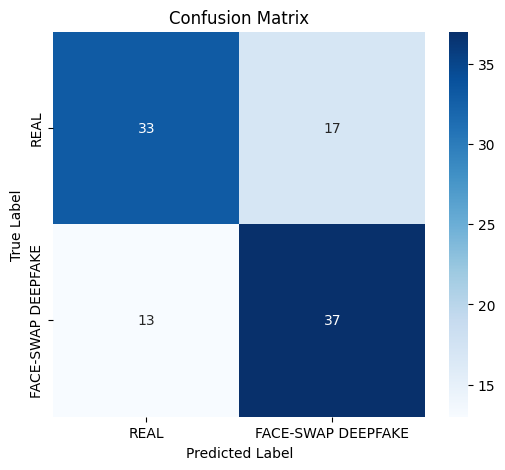

=== ROC AUC ===

📈 AUC Score: 0.7316


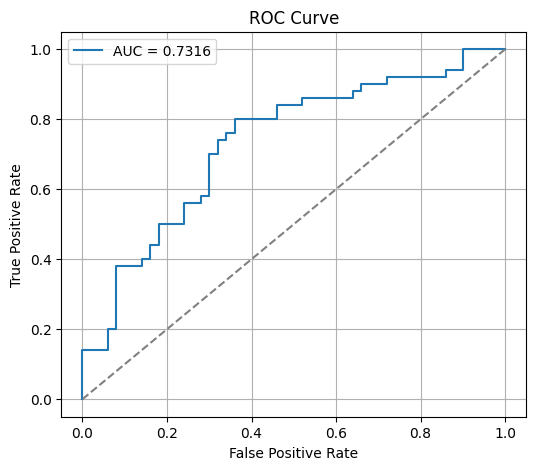

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

pt_folder = "Dataset Deepfake Preprocessed/Preprocessed Wajah/testing/testing 1080p"

# Loop seluruh file
for filename in sorted(os.listdir(pt_folder)):
    if not filename.endswith(".pt"):
        continue

    filepath = os.path.join(pt_folder, filename)
    data = torch.load(filepath)

    frames = torch.stack(data['frames']).unsqueeze(0).to(device)

    true_label = data['label'].item()

    with torch.no_grad():
        outputs = model(frames)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted = int(np.argmax(probabilities))
        probs_class1.append(probabilities[1])

    true_labels.append(true_label)
    predicted_labels.append(predicted)
    
# Classification Report
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# Confusion Matrix
print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# AUC Score
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

Model CNN-BiLSTM Bibir-Audio Terbaik

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.69      1.00      0.81        48
LIP-SYNC DEEPFAKE       1.00      0.55      0.71        49

         accuracy                           0.77        97
        macro avg       0.84      0.78      0.76        97
     weighted avg       0.84      0.77      0.76        97

=== CONFUSION MATRIX ===


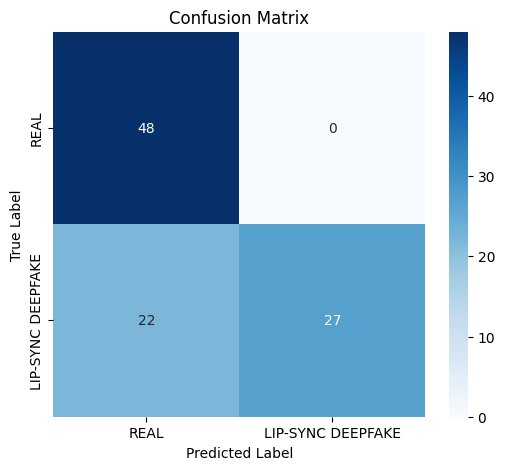

=== ROC AUC ===

📈 AUC Score: 0.8465


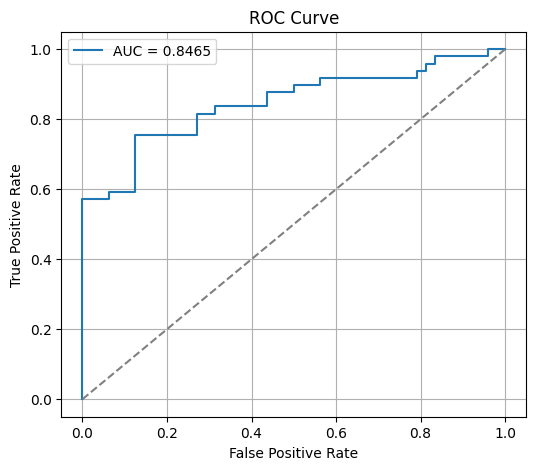

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 1080p")
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
        outputs = model(frames, audio)
        
        probs = torch.softmax(outputs, dim=1)
        probs_class1.extend(probs[:, 1].cpu().numpy())

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        true = labels.cpu().numpy()

        pred_labels.extend(preds)
        true_labels.extend(true)
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

**Test Kualitas Video 720p**

Model CNN-BiLSTM Wajah Terbaik

=== CLASSIFICATION REPORT ===
                    precision    recall  f1-score   support

              REAL       0.70      0.52      0.60        50
FACE-SWAP DEEPFAKE       0.62      0.78      0.69        50

          accuracy                           0.65       100
         macro avg       0.66      0.65      0.64       100
      weighted avg       0.66      0.65      0.64       100

=== CONFUSION MATRIX ===


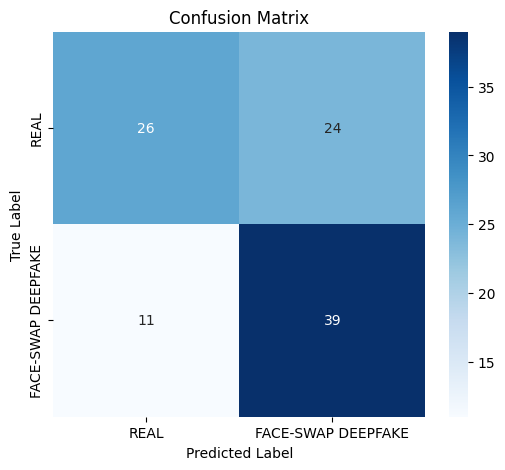

=== ROC AUC ===

📈 AUC Score: 0.6834


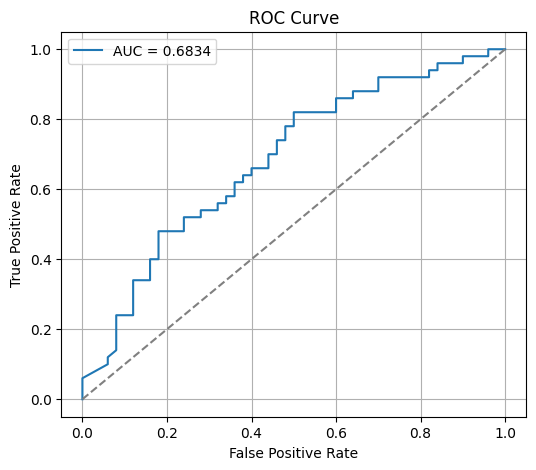

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

pt_folder = "Dataset Deepfake Preprocessed/Preprocessed Wajah/testing/testing 720p"

# Loop seluruh file
for filename in sorted(os.listdir(pt_folder)):
    if not filename.endswith(".pt"):
        continue

    filepath = os.path.join(pt_folder, filename)
    data = torch.load(filepath)

    frames = torch.stack(data['frames']).unsqueeze(0).to(device)

    true_label = data['label'].item()

    with torch.no_grad():
        outputs = model(frames)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted = int(np.argmax(probabilities))
        probs_class1.append(probabilities[1])

    true_labels.append(true_label)
    predicted_labels.append(predicted)
    
# Classification Report
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# Confusion Matrix
print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# AUC Score
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

Model CNN-BiLSTM Bibir-Audio Terbaik

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.71      1.00      0.83        45
LIP-SYNC DEEPFAKE       1.00      0.60      0.75        45

         accuracy                           0.80        90
        macro avg       0.86      0.80      0.79        90
     weighted avg       0.86      0.80      0.79        90

=== CONFUSION MATRIX ===


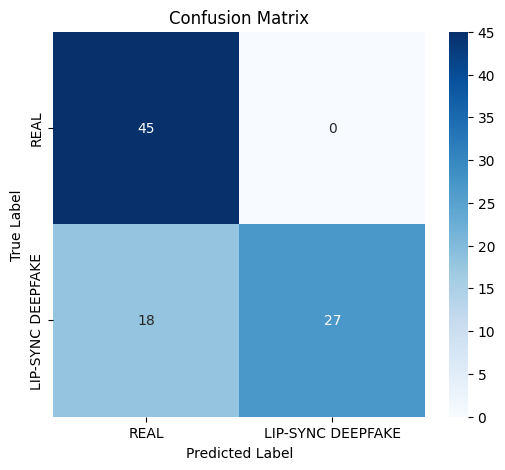

=== ROC AUC ===

📈 AUC Score: 0.8528


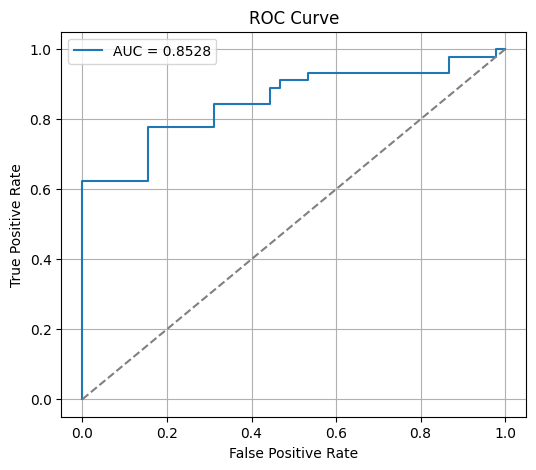

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 720p")
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
        outputs = model(frames, audio)
        
        probs = torch.softmax(outputs, dim=1)
        probs_class1.extend(probs[:, 1].cpu().numpy())

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        true = labels.cpu().numpy()

        pred_labels.extend(preds)
        true_labels.extend(true)
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

**Test Kualitas Video 480p**

Model CNN-BiLSTM Wajah Terbaik

=== CLASSIFICATION REPORT ===
                    precision    recall  f1-score   support

              REAL       0.60      0.30      0.40        50
FACE-SWAP DEEPFAKE       0.53      0.80      0.64        50

          accuracy                           0.55       100
         macro avg       0.57      0.55      0.52       100
      weighted avg       0.57      0.55      0.52       100

=== CONFUSION MATRIX ===


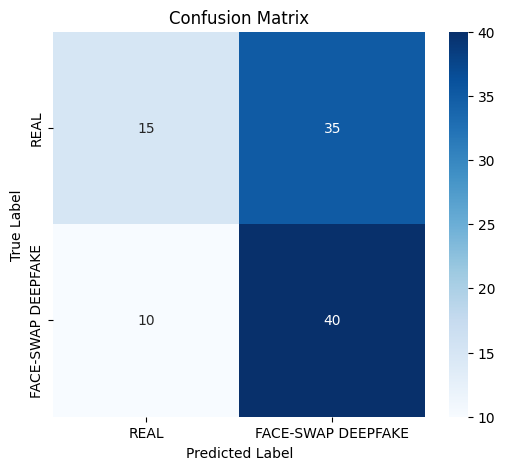

=== ROC AUC ===

📈 AUC Score: 0.5180


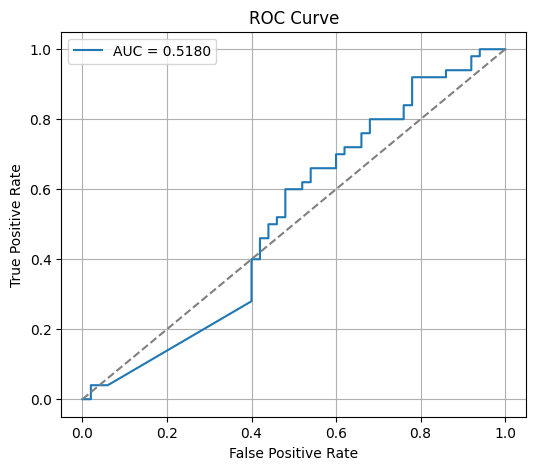

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

pt_folder = "Dataset Deepfake Preprocessed/Preprocessed Wajah/testing/testing 480p"

# Loop seluruh file
for filename in sorted(os.listdir(pt_folder)):
    if not filename.endswith(".pt"):
        continue

    filepath = os.path.join(pt_folder, filename)
    data = torch.load(filepath)

    frames = torch.stack(data['frames']).unsqueeze(0).to(device)

    true_label = data['label'].item()

    with torch.no_grad():
        outputs = model(frames)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted = int(np.argmax(probabilities))
        probs_class1.append(probabilities[1])

    true_labels.append(true_label)
    predicted_labels.append(predicted)
    
# Classification Report
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# Confusion Matrix
print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# AUC Score
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

Test Model CNN-BiLSTM Bibir-Audio Terbaik

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.68      1.00      0.81        30
LIP-SYNC DEEPFAKE       1.00      0.53      0.70        30

         accuracy                           0.77        60
        macro avg       0.84      0.77      0.75        60
     weighted avg       0.84      0.77      0.75        60

=== CONFUSION MATRIX ===


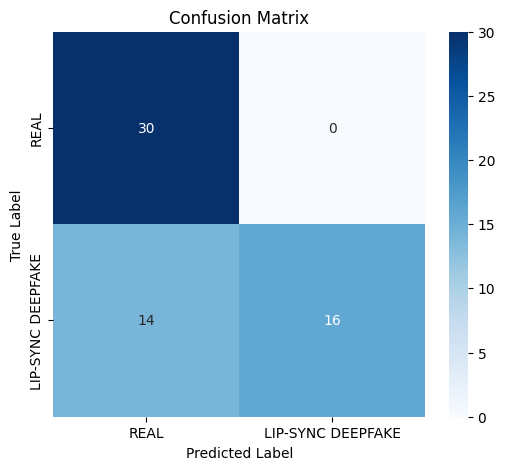

=== ROC AUC ===

📈 AUC Score: 0.8356


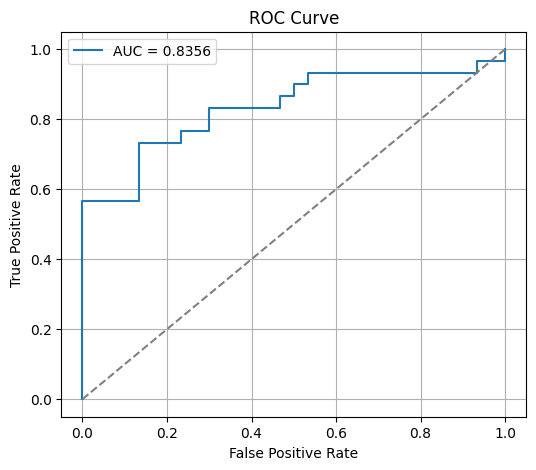

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 480p")
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
        outputs = model(frames, audio)
        
        probs = torch.softmax(outputs, dim=1)
        probs_class1.extend(probs[:, 1].cpu().numpy())

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        true = labels.cpu().numpy()

        pred_labels.extend(preds)
        true_labels.extend(true)
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

**Test Kualitas Video 360p**

Model CNN-BiLSTM Wajah Terbaik

=== CLASSIFICATION REPORT ===
                    precision    recall  f1-score   support

              REAL       0.71      0.42      0.53        24
FACE-SWAP DEEPFAKE       0.60      0.84      0.70        25

          accuracy                           0.63        49
         macro avg       0.66      0.63      0.61        49
      weighted avg       0.66      0.63      0.61        49

=== CONFUSION MATRIX ===


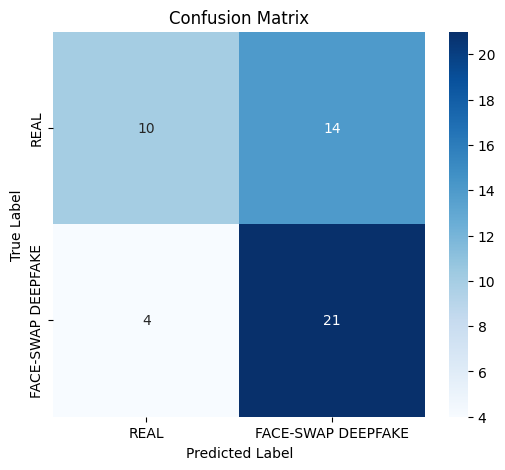

=== ROC AUC ===

📈 AUC Score: 0.6850


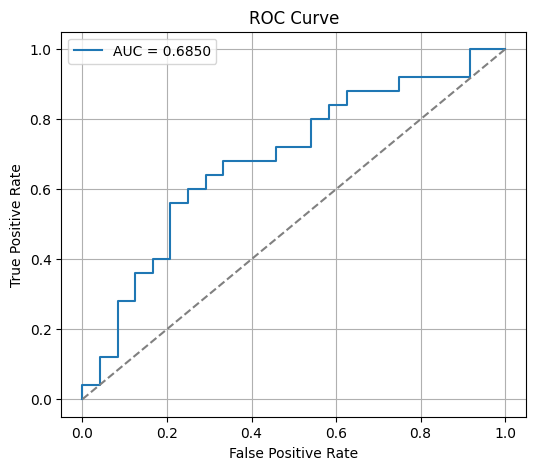

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

pt_folder = "Dataset Deepfake Preprocessed/Preprocessed Wajah/testing/testing 360p"

# Loop seluruh file
for filename in sorted(os.listdir(pt_folder)):
    if not filename.endswith(".pt"):
        continue

    filepath = os.path.join(pt_folder, filename)
    data = torch.load(filepath)

    frames = torch.stack(data['frames']).unsqueeze(0).to(device)

    true_label = data['label'].item()

    with torch.no_grad():
        outputs = model(frames)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted = int(np.argmax(probabilities))
        probs_class1.append(probabilities[1])

    true_labels.append(true_label)
    predicted_labels.append(predicted)
    
# Classification Report
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# Confusion Matrix
print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# AUC Score
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

Test Model CNN-BiLSTM Bibir-Audio Terbaik

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


=== CLASSIFICATION REPORT ===
                   precision    recall  f1-score   support

             REAL       0.50      1.00      0.67        22
LIP-SYNC DEEPFAKE       0.00      0.00      0.00        22

         accuracy                           0.50        44
        macro avg       0.25      0.50      0.33        44
     weighted avg       0.25      0.50      0.33        44

=== CONFUSION MATRIX ===


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

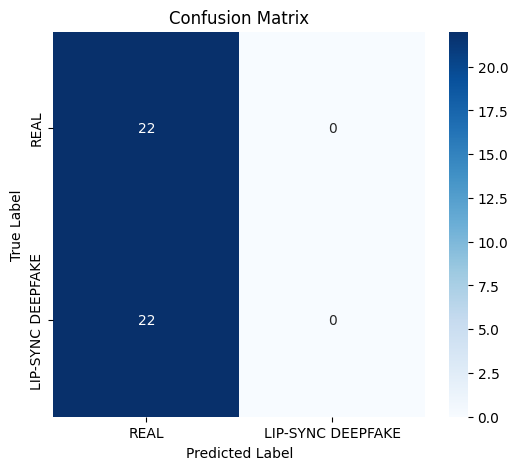

=== ROC AUC ===

📈 AUC Score: 0.2562


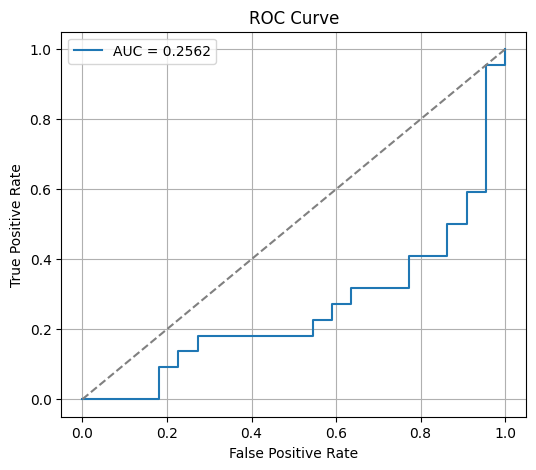

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


test_set = MultimodalDeepfakeDataset("Dataset Deepfake Preprocessed/Preprocessed Bibir Audio/testing/testing 360p")
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

true_labels = []
pred_labels = []
probs_class1 = []

with torch.no_grad():
    for frames, audio, labels in test_loader:
        frames, audio = frames.to(device), audio.to(device)
        outputs = model(frames, audio)
        
        probs = torch.softmax(outputs, dim=1)
        probs_class1.extend(probs[:, 1].cpu().numpy())

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        true = labels.cpu().numpy()

        pred_labels.extend(preds)
        true_labels.extend(true)
        
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, target_names=["REAL", "LIP-SYNC DEEPFAKE"]))

print("=== CONFUSION MATRIX ===")
cm = confusion_matrix(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "LIP-SYNC DEEPFAKE"], yticklabels=["REAL", "LIP-SYNC DEEPFAKE"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC & AUC
print("=== ROC AUC ===")
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()